In [33]:
import pandas as pd

# Load the dataset
file_path = 'crash_report.csv'  
df = pd.read_csv(file_path)

# Inspect the first few rows of the dataset
df.head()

/opt/jupyterhub/pyvenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3433: DtypeWarning: Columns (7,53) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,crash_id,crash_fatal_fl,crash_date,crash_time,case_id,rpt_latitude,rpt_longitude,rpt_block_num,rpt_street_pfx,rpt_street_name,...,pedestrian_serious_injury_count,motorcycle_death_count,motorcycle_serious_injury_count,other_death_count,other_serious_injury_count,onsys_fl,private_dr_fl,micromobility_serious_injury_count,micromobility_death_count,micromobility_fl
0,13604792,N,12/09/2013 05:13:00 AM,05:13:00,133430257,NaN,NaN,12500,NaN,NOT REPORTED,...,0,0,0,0,0,Y,N,0,0,NaN
1,13643587,N,01/16/2014 02:44:00 AM,02:44:00,140160143,NaN,NaN,6200,NaN,NOT REPORTED,...,0,0,0,0,0,Y,N,0,0,NaN
2,13626786,N,01/05/2014 10:31:00 PM,22:31:00,140051531,NaN,NaN,8000,NaN,NOT REPORTED,...,0,0,0,0,0,Y,N,0,0,NaN
3,13634908,N,01/09/2014 06:54:00 AM,06:54:00,140090303,NaN,NaN,7500,NaN,NOT REPORTED,...,0,0,0,0,0,Y,N,0,0,NaN
4,13635567,N,11/29/2013 02:44:00 AM,02:44:00,133330181,NaN,NaN,NaN,NaN,RESEARCH NB TO MOPAC SB RAMP,...,0,0,0,0,0,Y,N,0,0,NaN


In [34]:
# Data Preprocessing

# Encode the target variable into binary format
df['crash_fatal_fl'] = df['crash_fatal_fl'].map({'Y': 1, 'N': 0})

# Check the distribution of the target variable
print("Distribution after encoding:")
print(df['crash_fatal_fl'].value_counts())

# Handle missing values in features and target
df = df.dropna(subset=['rpt_latitude', 'rpt_longitude'])  # Drop rows where latitude and longitude are missing
df.fillna({'crash_fatal_fl': 0}, inplace=True)  # Assuming '0' for missing values in the fatal crash flag

# Convert crash_date to datetime and extract hour
df['crash_date'] = pd.to_datetime(df['crash_date'])
df['hour_of_day'] = df['crash_date'].dt.hour

# Select relevant features and target
features = ['hour_of_day', 'rpt_latitude', 'rpt_longitude']
target = 'crash_fatal_fl'
X = df[features]
y = df[target]

# Handling NaN values in X and y
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

# Handling infinite values in X
import numpy as np
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

# Check for any remaining NaN, infinity, or large values in features
if X.isna().any().any():
    raise ValueError("NaN values found in the features after handling.")
if np.isinf(X.values).any():
    raise ValueError("Infinite values found in the features after handling.")



Distribution after encoding:
0    147566
1       860
Name: crash_fatal_fl, dtype: int64


/opt/jupyterhub/pyvenv/lib/python3.8/site-packages/pandas/core/generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/opt/jupyterhub/pyvenv/lib/python3.8/site-packages/pandas/core/frame.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Split data into training and test sets, with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify the distribution in training and test sets
print("Training set distribution:")
print(y_train.value_counts())
print("Test set distribution:")
print(y_test.value_counts())

# Initialize and train the Logistic Regression model with class_weight='balanced'
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Initialize and train the Decision Tree model
dtree = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dtree.fit(X_train, y_train)

# Make predictions with the Decision Tree
y_pred_dtree = dtree.predict(X_test)

# Evaluate the Decision Tree model
print("Decision Tree Model Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred_dtree))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dtree))




Training set distribution:
0    6824
1      28
Name: crash_fatal_fl, dtype: int64
Test set distribution:
0    1706
1       7
Name: crash_fatal_fl, dtype: int64
Accuracy: 0.6246351430239346

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.63      0.77      1706
           1       0.00      0.29      0.01         7

    accuracy                           0.62      1713
   macro avg       0.50      0.46      0.39      1713
weighted avg       0.99      0.62      0.77      1713

Decision Tree Model Evaluation
Accuracy: 0.9918272037361354

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1706
           1       0.00      0.00      0.00         7

    accuracy                           0.99      1713
   macro avg       0.50      0.50      0.50      1713
weighted avg       0.99      0.99      0.99      1713



In [36]:

def predict_fatal_crash(hour, latitude, longitude):
    """
    Predict the probability of a crash being fatal at a given hour, latitude, and longitude.
    """
    input_data = np.array([[hour, latitude, longitude]])
    prob_fatal = log_reg.predict_proba(input_data)[0][1]
    return prob_fatal


def predict_fatal_crash_dtree(hour, latitude, longitude):
    """
    Predict the probability of a crash being fatal at a given hour, latitude, and longitude using the Decision Tree model.
    """
    input_data = np.array([[hour, latitude, longitude]])
    prob_fatal = dtree.predict_proba(input_data)[0][1]
    return prob_fatal


hour = 15  # 3 PM
latitude = 30.2672  # Some location in Austin
longitude = -97.7431
probability = predict_fatal_crash(hour, latitude, longitude)
print(f"Logistic Regression: Probability of a fatal crash at {hour}:00 in location ({latitude}, {longitude}): {probability:.2f}")
probability_dtree = predict_fatal_crash_dtree(hour, latitude, longitude)
print(f"Decision Tree: Probability of a fatal crash at {hour}:00 in location ({latitude}, {longitude}): {probability_dtree:.2f}")


Logistic Regression: Probability of a fatal crash at 15:00 in location (30.2672, -97.7431): 0.47
Decision Tree: Probability of a fatal crash at 15:00 in location (30.2672, -97.7431): 0.00


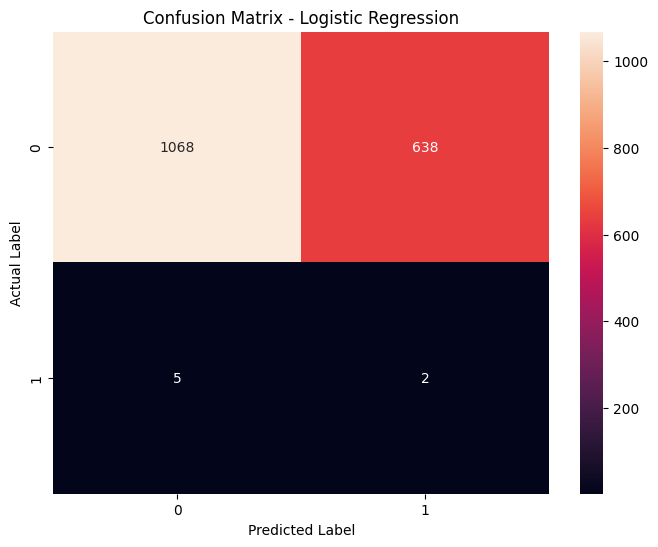

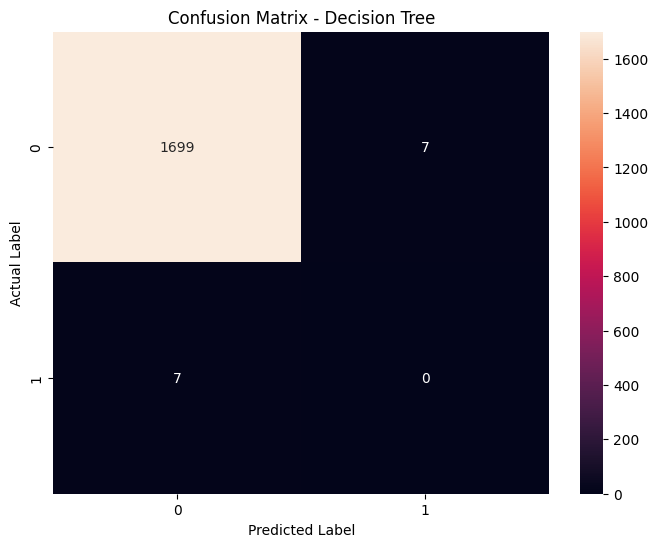

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix for Logistic Regression
cm_log_reg = confusion_matrix(y_test, log_reg.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_log_reg, annot=True, fmt="d")
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Confusion Matrix for Decision Tree
cm_dtree = confusion_matrix(y_test, dtree.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dtree, annot=True, fmt="d")
plt.title("Confusion Matrix - Decision Tree")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()




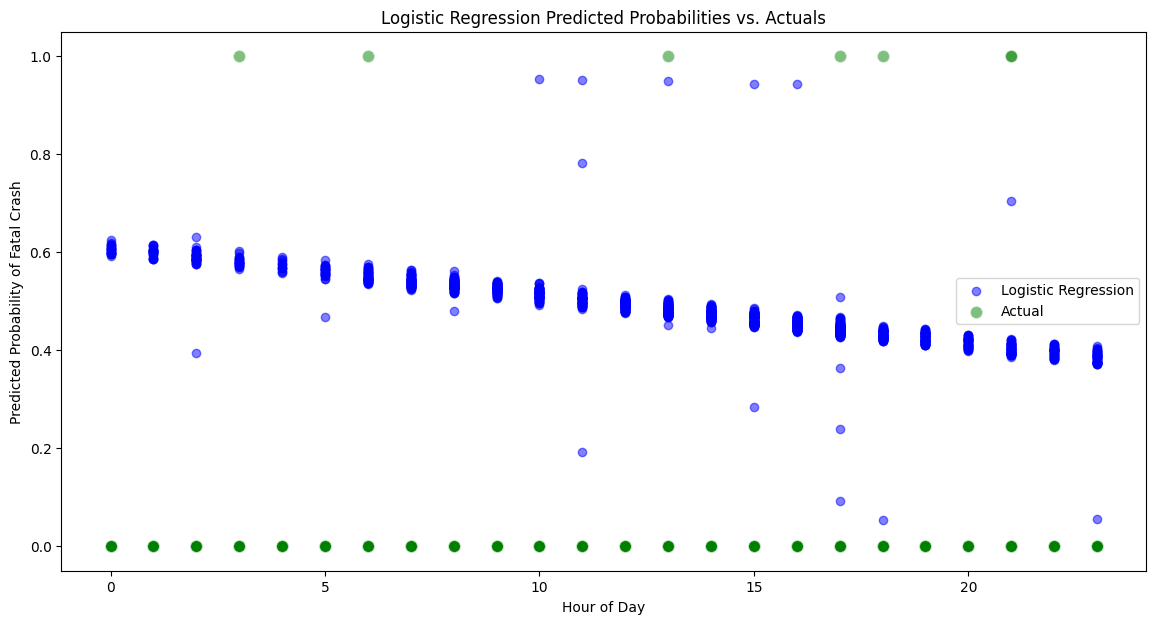

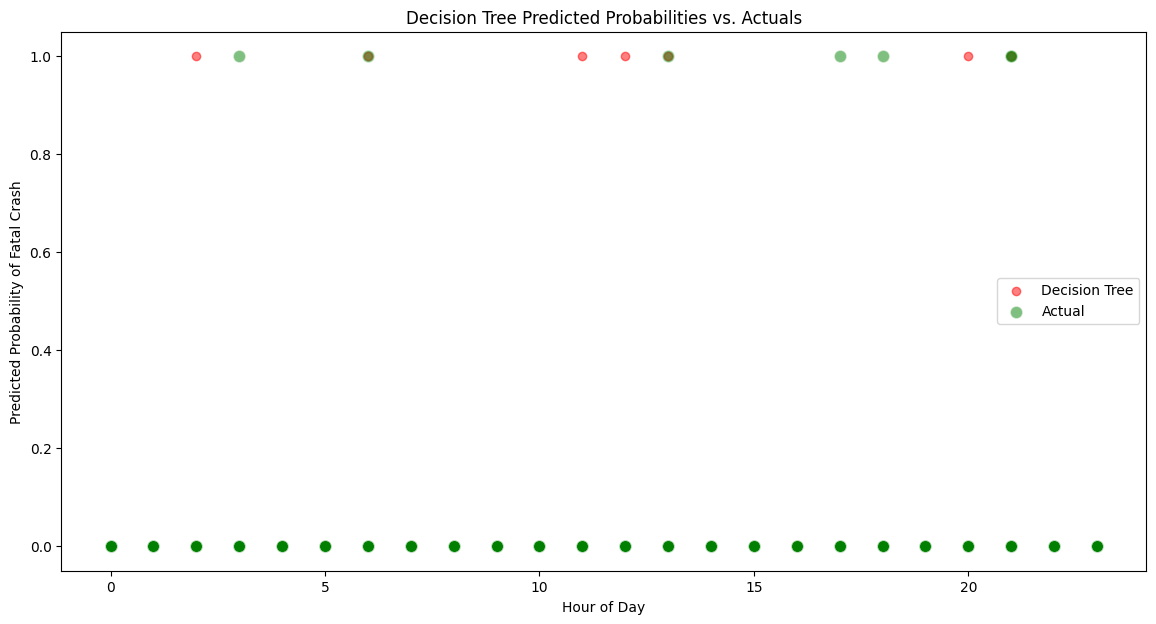

In [38]:
import matplotlib.pyplot as plt

# Get predicted probabilities for the test set from both models
probabilities_log_reg = log_reg.predict_proba(X_test)[:, 1]
probabilities_dtree = dtree.predict_proba(X_test)[:, 1]

# Create a scatter plot for Logistic Regression predictions
plt.figure(figsize=(14, 7))
plt.scatter(X_test['hour_of_day'], probabilities_log_reg, c='blue', label='Logistic Regression', alpha=0.5)
plt.scatter(X_test['hour_of_day'], y_test, c='green', label='Actual', alpha=0.5, edgecolors='w', s=80)
plt.title('Logistic Regression Predicted Probabilities vs. Actuals')
plt.xlabel('Hour of Day')
plt.ylabel('Predicted Probability of Fatal Crash')
plt.legend()
plt.show()

# Create a scatter plot for Decision Tree predictions
plt.figure(figsize=(14, 7))
plt.scatter(X_test['hour_of_day'], probabilities_dtree, c='red', label='Decision Tree', alpha=0.5)
plt.scatter(X_test['hour_of_day'], y_test, c='green', label='Actual', alpha=0.5, edgecolors='w', s=80)
plt.title('Decision Tree Predicted Probabilities vs. Actuals')
plt.xlabel('Hour of Day')
plt.ylabel('Predicted Probability of Fatal Crash')
plt.legend()
plt.show()


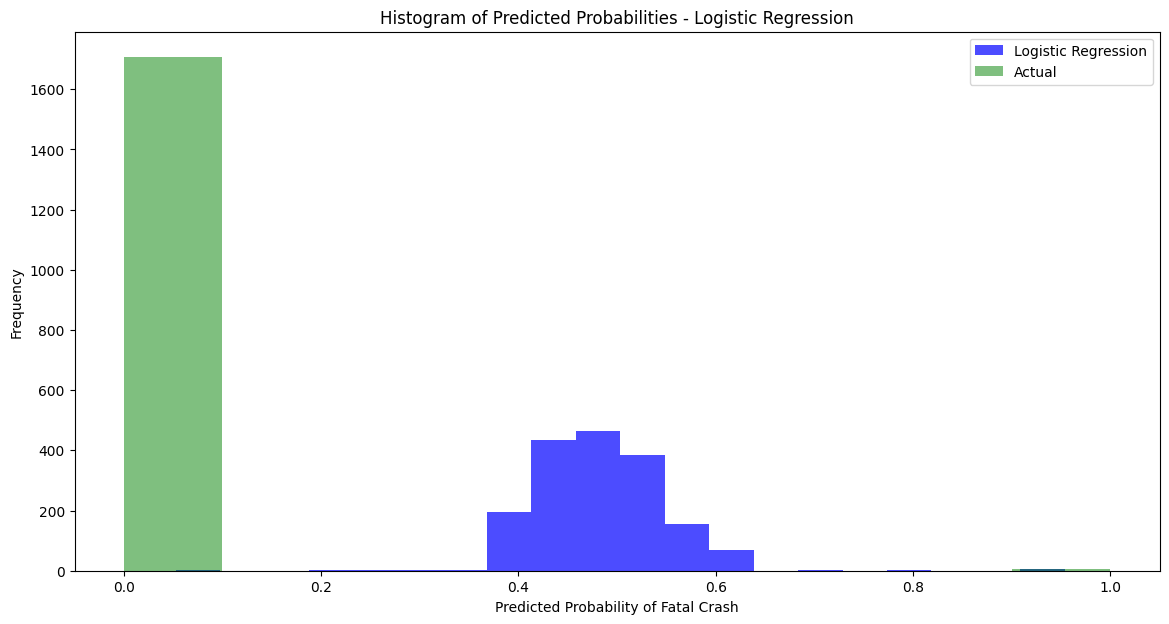

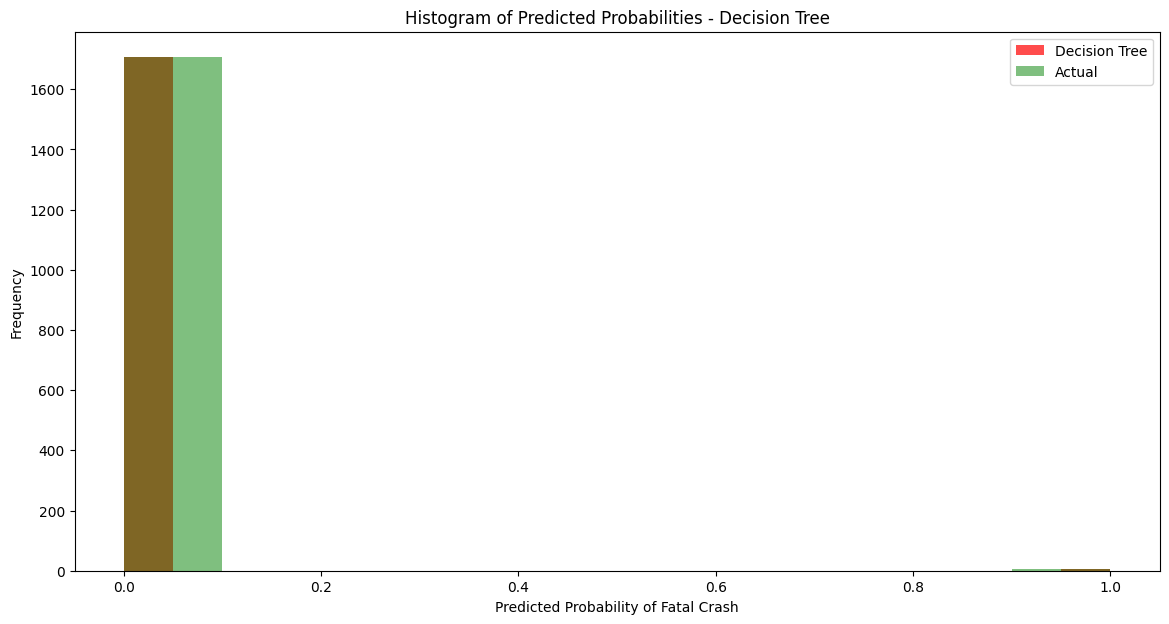

In [39]:
# Histogram of predicted probabilities for Logistic Regression
plt.figure(figsize=(14, 7))
plt.hist(probabilities_log_reg, bins=20, color='blue', alpha=0.7, label='Logistic Regression')
plt.hist(y_test, bins=10, color='green', alpha=0.5, label='Actual')
plt.title('Histogram of Predicted Probabilities - Logistic Regression')
plt.xlabel('Predicted Probability of Fatal Crash')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Histogram of predicted probabilities for Decision Tree
plt.figure(figsize=(14, 7))
plt.hist(probabilities_dtree, bins=20, color='red', alpha=0.7, label='Decision Tree')
plt.hist(y_test, bins=10, color='green', alpha=0.5, label='Actual')
plt.title('Histogram of Predicted Probabilities - Decision Tree')
plt.xlabel('Predicted Probability of Fatal Crash')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [42]:
from sklearn.tree import DecisionTreeClassifier


dtree = DecisionTreeClassifier(max_depth=3, random_state=42) 
dtree.fit(X, y)


DecisionTreeClassifier(max_depth=2, random_state=42)

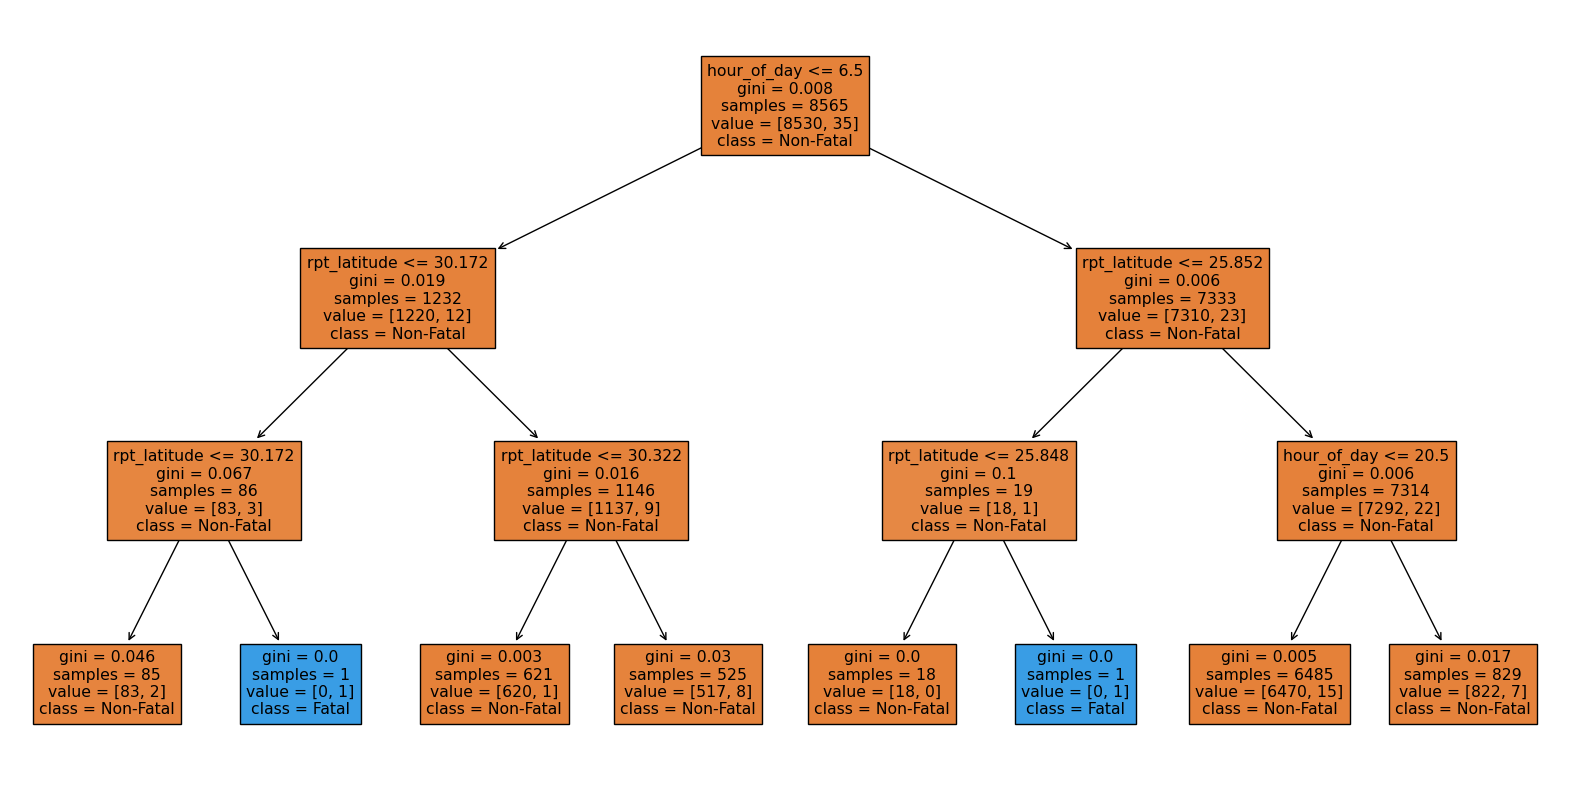

In [41]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dtree, filled=True, feature_names=X.columns, class_names=['Non-Fatal', 'Fatal'])
plt.show()
